## Librairies

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
sns.set_style("whitegrid")

##  Assumption tester for OLS model

In [2]:
class Assumption_Tester_OLS:
    """
   X - Pandas DataFrame with numerical values. Independent Variable
   y - Series with numerical values. Dependent Variable
    
    Tests a linear regression on the model to see if assumptions are being met

    """
    
    from sklearn.linear_model import LinearRegression
    
    def __init__(self, X,y):
        from numpy import ndarray
        from pandas import concat
        from pandas.core.frame import DataFrame
        from pandas.core.series import Series

        if type(X) == ndarray:
            self.features = ['X'+str(feature+1) for feature in range(X.shape[1])]
        elif type(X) == DataFrame:
            self.features=X.columns.to_list()
        else:
            print('Expected numpy array or pandas dataframe as X')
            return
        if type(y) == ndarray:
            self.output = 'y'
        elif type(y) == DataFrame:
            self.output=y.columns[0]
        elif type(y) == Series:
            self.output=y.name
        else:
            print('Expected numpy array or pandas dataframe as X')
            return

        self.X = X.values if type(X)==DataFrame else X
        self.y=y.iloc[:,0].values if type(y)==DataFrame else y.values if type(y)==Series else y
        
        self.model='not built yet'
        self.r2=0
        self.results={'Satisfied':[],'Potentially':[],'Violated':[]}
    
   
    def fit_model(self):
        from sklearn.linear_model import LinearRegression
        
        print('Fitting linear regression')        
        
        #Multi-threading when needed
        if self.X.shape[0] > 100000:
            self.model = LinearRegression(n_jobs=-1)
        else:
            self.model = LinearRegression()
        self.model.fit(self.X, self.y)
        
        self.predictions = self.model.predict(self.X)
        self.resid = self.y - self.predictions
        
        
    def build_model(self):
        self.fit_model()
        
        # Returning linear regression R^2 and coefficients before performing diagnostics
        self.r2 = self.model.score(self.X, self.y)
        print()
        print('R^2:', self.r2, '\n')
        print('Coefficients')
        print('-------------------------------------')
        print('Intercept:', self.model.intercept_)
        for idx,feature in enumerate(self.model.coef_):
            print(f'{self.features[idx]}: {round(feature,2)}')

    def linearity(self):
        """
        Linearity: Assumes there is a linear relationship between the predictors and
                   the response variable. If not, either a polynomial term or another
                   algorithm should be used.
        """
        from pandas import concat
        from numpy import arange
        from pandas.core.frame import DataFrame
        from pandas.core.series import Series        
        import seaborn as sns
        sns.set()
        import matplotlib.pyplot as plt
        
        if type(self.model)==str:
            self.fit_model()
        
        print('\n=======================================================================================')
        print('Assumption 1: Linear Relationship between the Target and the Features')
        print('Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.')
        
        # Plotting the actual vs predicted values
        sns.regplot(self.y,self.predictions, fit_reg=False)
        
        # Plotting the diagonal line
        line_coords = arange(min(self.y.min(),self.predictions.min()), max(self.y.max(),self.predictions.max()))
        plt.plot(line_coords, line_coords,  # X and y points
                 color='darkorange', linestyle='--')
        plt.title('Actual vs. Predicted')
        plt.show()
        print('If non-linearity is apparent, consider adding a polynomial term \n\t\tor using box-cox transformation to make X or y follow normal distribution')
        
        print('\n\n\nBuilding a correlation table')
        print('\n=======================================================================================')
        df=concat([DataFrame(self.X),Series(self.y)],axis=1)
        df.columns=self.features+[self.output]
        df_corr=df[df.nunique()[df.nunique()>2].index].corr()[self.output].drop(self.output)
        
        print(f'\nParameters that are most likely VIOLATE linearity assumption and their correlation with {self.output}')
        display(df_corr[abs(df_corr)<0.25])

        print(f'\nParameters that are most likely FOLLOW linearity assumption and their correlation with {self.output}')
        display(df_corr[abs(df_corr)>=0.25])
        
        
        if df_corr[abs(df_corr)<0.25].shape[0]==0:
            self.results['Satisfied'].append('Linearity')
        elif df_corr[abs(df_corr)>=0.25].shape[0]==0:
            self.results['Violated'].append('Linearity')
        else:
            self.results['Potentially'].append('Linearity')
        
    def multicollinearity(self):
        """
        Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                           correlation among the predictors, then either remove prepdictors with high
                           Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           This assumption being violated causes issues with interpretability of the 
                           coefficients and the standard errors of the coefficients.
        """
        from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
        import matplotlib.pyplot as plt
        import seaborn as sns
        from pandas.core.frame import DataFrame
        sns.set()
        
        if type(self.model)==str:
            self.fit_model()
            
        print('\n=======================================================================================')
        print('Assumption 2: Little to no multicollinearity among predictors')
        # Plotting the heatmap
        plt.figure(figsize = (10,8))
        sns.heatmap(DataFrame(self.X, columns=self.features).corr(), annot=len(self.features)<10, center=0, cmap=sns.diverging_palette(220, 20, as_cmap=True))
        plt.title('Correlation of Variables')
        plt.show()
        print('Variance Inflation Factors (VIF)')
        print('> 10: An indication that multicollinearity may be present')
        print('> 100: Certain multicollinearity among the variables')
        print('-------------------------------------')
        # Gathering the VIF for each variable
        vifs = {i:VIF(self.X, idx) for idx,i in enumerate(self.features)}
        vifs = dict(sorted(vifs.items(), key=lambda x: x[1], reverse=True))
        for key, vif in vifs.items():
            print(f'{key}: {vif}')
        # Gathering and printing total cases of possible or definite multicollinearity
        possible_multicollinearity = sum([1 for vif in vifs.values() if vif > 10])
        definite_multicollinearity = sum([1 for vif in vifs.values() if vif > 100])
        print()
        print(f'{possible_multicollinearity} cases of possible multicollinearity')
        print(f'{definite_multicollinearity} cases of definite multicollinearity')
        print()
        if definite_multicollinearity == 0:
            if possible_multicollinearity == 0:
                print('Assumption satisfied')
                self.results['Satisfied'].append('Multicollinearity')
            else:
                print('Assumption possibly satisfied')
                print()
                print('Coefficient interpretability may be problematic')
                print('Consider removing variables with a high Variance Inflation Factor (VIF)')
                self.results['Potentially'].append('Multicollinearity')

        else:
            print('Assumption not satisfied')
            print()
            print('Coefficient interpretability will be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')
            self.results['Violated'].append('Multicollinearity')
            

    
    def autocorrelation(self):
        """
        Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                         autocorrelation, then there is a pattern that is not explained due to
                         the current value being dependent on the previous value.
                         This may be resolved by adding a lag variable of either the dependent
                         variable or some of the predictors.
        """
        from statsmodels.stats.stattools import durbin_watson        
        
        if type(self.model)==str:
            self.fit_model()
        print('\n=======================================================================================')
        print('Assumption 3: No Autocorrelation')
        print('\nPerforming Durbin-Watson Test')
        print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
        print('0 to 2< is positive autocorrelation')
        print('>2 to 4 is negative autocorrelation')
        print('-------------------------------------')
        durbinWatson = durbin_watson(self.resid)
        print('Durbin-Watson:', durbinWatson)
        if durbinWatson < 1.5:
            print('Signs of positive autocorrelation', '\n')
            print('Assumption not satisfied', '\n')
            self.results['Violated'].append('Autocorrelation')
        elif durbinWatson > 2.5:
            print('Signs of negative autocorrelation', '\n')
            print('Assumption not satisfied', '\n')
            self.results['Violated'].append('Autocorrelation')
        else:
            print('Little to no autocorrelation', '\n')
            print('Assumption satisfied')
            self.results['Satisfied'].append('Autocorrelation')
            

    def homoskedasticity(self,p_value_thresh=0.05):
        """
        Homoskedasticity: Assumes that the errors exhibit constant variance
        """
        
        from statsmodels.stats.diagnostic import het_breuschpagan
        
        import matplotlib.pyplot as plt
        import seaborn
        from numpy import repeat
        seaborn.set()
        
        if type(self.model)==str:
            self.fit_model()
            
        print('\n=======================================================================================')
        print('Assumption 4: Homoskedasticity of Error Terms')
        print('Residuals should have relative constant variance')
        # Plotting the residuals
        plt.subplots(figsize=(12, 6))
        ax = plt.subplot(111)  # To remove spines
        plt.scatter(x=range(self.X.shape[0]), y=self.resid, alpha=0.5)
        plt.plot(repeat(0, self.X.shape[0]), color='darkorange', linestyle='--')
        ax.spines['right'].set_visible(False)  # Removing the right spine
        ax.spines['top'].set_visible(False)  # Removing the top spine
        plt.title('Residuals')
        plt.show() 
        print('If heteroskedasticity is apparent, confidence intervals and predictions will be affected')        
        print('\nConsider removing outliers and preprocessing features - nonlinear transformation can help')
        
        lnames=['Lagrange Multiplier', 'pvalue for LM','F stats','pvalue for Fstats']
        display({lnames[idx]:het_breuschpagan(self.resid,self.X)[idx] for idx in range(4)})
        if het_breuschpagan(self.resid,self.X)[3] < p_value_thresh:
            print('Signs of positive autocorrelation', '\n')
            print('Assumption potentially not satisfied', '\n')
            self.results['Potentially'].append('Autocorrelation')
        else:
            print('Signs of negative autocorrelation', '\n')
            print('Assumption satisfied', '\n')
            self.results['Satisfied'].append('Autocorrelation')

       
        
    def normality_resid(self,p_value_thresh=0.05):
        """
        Normality: Assumes that the error terms are normally distributed. If they are not,
        nonlinear transformations of variables may solve this.
        This assumption being violated primarily causes issues with the confidence intervals
        """
        from statsmodels.stats.diagnostic import normal_ad
        from scipy.stats import probplot
        import pylab
        import matplotlib.pyplot as plt
        import seaborn as sns
        from numpy import quantile,logical_or
        sns.set()

        if type(self.model)==str:
            self.fit_model()
            
        print('\n=======================================================================================')
        print('Assumption 5: The error terms are kinda normally distributed')
        print()
        print('Using the Anderson-Darling test for normal distribution')
        # Performing the test on the residuals
        p_value = normal_ad(self.resid)[1]
        print('p-value from the test - below 0.05 generally means non-normal:', p_value)
        # Reporting the normality of the residuals
        if p_value < p_value_thresh:
            print('Residuals are not normally distributed')
        else:
            print('Residuals are normally distributed')
        # Plotting the residuals distribution
        plt.subplots(figsize=(12, 6))
        plt.title('Distribution of Residuals')
        sns.distplot(self.resid)
        plt.show()
        print()
        if p_value > p_value_thresh:
            print('Assumption satisfied')
            self.results['Satisfied'].append('Normality')
        else:
            print('Assumption not satisfied')
            self.results['Violated'].append('Normality')
            print()
            print('Confidence intervals will likely be affected')
            print('Try performing nonlinear transformations on variables')
    
    
        print('Building a probability plot')
        quantiles=probplot(self.resid, dist='norm', plot=pylab);
        plt.show()
        qqq=(quantiles[0][1]-quantiles[0][1].mean())/quantiles[0][1].std()-quantiles[0][0]
        q75=quantile(qqq,0.75)
        q25=quantile(qqq,0.25)

        outliers_share=(logical_or(qqq>q75+(q75-q25)*1.7, qqq<q25-(q75-q25)*1.7).sum()/qqq.shape[0]).round(3)
        if outliers_share<0.005:
            print('Assumption can be considered as satisfied.')
            self.results['Satisfied'].append('Sub-Normality')
        elif outliers_share<0.05:
            self.results['Potentially'].append('Sub-Normality')
            print(f'\nIn your dataset you quite fat tails. You have {outliers_share} potential outliers ({logical_or(qqq>q75+(q75-q25)*1.7, qqq<q25-(q75-q25)*1.7).sum()} rows)')
        else:
            print(f'\nIn fact outliers are super significant. Probably it is better to split your dataset into 2 different ones.')
            self.results['Violated'].append('Sub-Normality')


    def run_all(self):
        self.build_model()
        self.linearity()
        self.multicollinearity()
        self.autocorrelation()
        self.homoskedasticity()
        self.normality_resid()
        display(self.results)




## Matching Librairies with there arrondissement in Paris

In [ ]:
Arr=pd.read_csv('BibliothequeParis.txt',sep=':')

In [ ]:
Arr.head()

In [ ]:
lib=Arr['librairies'].str.split(',',expand=True)

In [ ]:
lib2=lib.fillna(0)

In [ ]:
lib2

In [ ]:
lib

In [ ]:
lib.iloc[0].count()

In [ ]:
pop=pd.read_csv('pop_arrondissement_paris',sep=',')

In [ ]:
pop['NBlibrairies']=0
for i in range(20):
    pop['NBlibrairies'].iloc[i]=lib.iloc[i].count()
    i+=1

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
plt.barh(pop.arrondissement,pop.population/pop.NBlibrairies)
plt.title('Nb of people per librairies for each arrondissement')
plt.xlabel('Nb people/librairies')
plt.ylabel('N° of arrondissement')

In [ ]:
dflilb=dataBook.iloc[:,38:97]

In [ ]:
dflilb.sum().index

In [ ]:
"""
for i in range(lib2.shape[0]):
    for j in range(lib2.shape[1]):
        if lib2.iloc[i,j]==0:
            lib2.iloc[i,j]=0
        else:
            lib2.iloc[i,j]=dflilb.sum()(lib2.iloc[i,j])"""
    

In [3]:
dataBook=pd.read_csv('/Users/sandrine//Desktop/Prework/Projects_Ironhack/Book_loan/docprets.csv',sep=';')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Target : Analyse book loan trends of Parisian people and predict the number of loans per book

The number of loans may depend on:
- the book age
- the librairie and its stock,
- the author,
- the publisher (column Editeur)
- the format
This is what I will check 

## Dataset cleaning

In [4]:
dataBook.head()

,N° de notice,ISBN,ISSN,EAN,Langue,Titre,Edition,Editeur,Date,Format,...,Vaclav Havel,Valeyre,Vandamme,Vaugirard,Auteur,Co-auteur,Auteur secondaire,Collectivité auteur,Collectivité auteur secondaire,Collectivité co-auteur
0,176870,NaN,NaN,NaN,français,La Politique étrangère en France | Texte impri...,NaN,Documentation française ;Ministère des affaire...,2003,386 p. | 28 cm,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FRANCE. Direction de la documentation française,France. Ministère des relations extérieures;Di...,NaN
1,176733,2-8435-2107-6,NaN,NaN,français,Voyages en Sicile | Texte imprimé | Dominique ...,NaN,"Diderot éditeur, arts et sciences",1998,1 vol. (299 p.) | 18 cm,...,NaN,NaN,NaN,NaN,"Denon, Dominique Vivant",NaN,NaN,NaN,NaN,NaN
2,176766,2-259-00278-1,NaN,NaN,français,0Voyages | [2] | Russie | Texte imprimé | Niko...,NaN,Plon,1977,322 p.-[1] f. de pl. | 20 cm,...,NaN,NaN,NaN,NaN,"Kazantzákīs, Níkos",NaN,"Princet, Liliane",NaN,NaN,NaN
3,176779,NaN,NaN,NaN,français,L'harmonica blues pour débutants | Texte imprimé,NaN,Emf,1997,1 méthode musicale (62 p.) | 30 cm | éventuell...,...,NaN,NaN,NaN,NaN,"Kinsella, Mick",NaN,NaN,NaN,NaN,NaN
4,176892,0-06-443063-4,NaN,NaN,anglais,A letter to Amy | Texte imprimé | Ezra Jack Keats,NaN,Harper Trophy,1984,30 p. | ill. en coul. | 21 cm,...,NaN,NaN,NaN,NaN,"Keats, Ezra Jack",NaN,NaN,NaN,NaN,NaN


In [5]:
#Check general info of dataset.
dataBook.shape,dataBook.dtypes

((815534, 103),
 N° de notice                        int64
 ISBN                               object
 ISSN                               object
 EAN                                object
 Langue                             object
                                     ...  
 Co-auteur                          object
 Auteur secondaire                  object
 Collectivité auteur                object
 Collectivité auteur secondaire     object
 Collectivité co-auteur             object
 Length: 103, dtype: object)

In [27]:
#Replace ' ' by '_in column names'
dataBook.columns=dataBook.columns.str.replace(' ','_')
#dataBook.columns.to_list()

In [7]:
dataBook['N°_de_notice'].unique().size==dataBook.shape[0]
#N°_de_notice could be an index for the dataset

True

In [8]:
# Prepare list of columns to drop due to missing values
to_drop=[]
to_drop.extend(dataBook.iloc[:,100:103].columns.to_list())
#Prepare list of columns for which we want to get dummies
Dummies_NA=[]
row_to_drop=[]

### Null values

In [10]:
#Check Number of Null values per columns
dataBook.isna().sum()

N°_de_notice                            0
ISBN                               323243
ISSN                               813046
EAN                                416532
Langue                              81024
                                    ...  
Co-auteur                          742302
Auteur_secondaire                  434716
Collectivité_auteur                778773
Collectivité_auteur_secondaire_    734515
Collectivité_co-auteur_            812309
Length: 103, dtype: int64

In [11]:
#Total number of Null values in the dataset
dataBook.isna().sum().sum()

62803925

### Author related columns 

In [12]:
#dataBook["Auteur_Dates"].value_counts()
#Column not necessary for the model so I drop it.
to_drop.append('Auteur_Dates')

In [ ]:
#check whether I can drop or replace 'Auteur', 'Auteur Prenom' and 'Auteur Nom' columns
dftest=dataBook[(dataBook['Auteur_Nom']+', '+dataBook['Auteur_Prénom'])!=dataBook['Auteur']]
df=dftest[(dftest['Auteur_Nom']==dftest['Auteur'])|(dftest['Auteur_Prénom']==dftest['Auteur'])]
df[['Auteur_Nom','Auteur_Prénom','Auteur']]

df1=dftest[(dftest['Auteur_Nom']!=dftest['Auteur'])&(dftest['Auteur_Prénom']!=dftest['Auteur'])]
df1[['Auteur_Nom','Auteur_Prénom','Auteur']]
df1['Auteur_Prénom'].isna().sum()==df1['Auteur_Nom'].isna().sum()==df1['Auteur'].isna().sum()
#Author column is a mix of columns 'Auteur_Nom' and 'Auteur_Prénom' . However the format of Author does not
#suit me.

#check whether I can drop or replace 'Auteur_secondaire_Nom', 'Auteur_secondaire_Prénom' 
#and 'Auteur_secondaire' columns. Auteur secondaire include translaters.
#df3=dataBook[(dataBook['Auteur_secondaire_Nom']+', '+dataBook['Auteur_secondaire_Prénom'])!=dataBook['Auteur_secondaire']]
#df3[['Auteur_secondaire_Nom','Auteur_secondaire_Prénom','Auteur_secondaire']]
# same conclusions as for Author.

In [13]:
# Function to merge first name and last name in one column
def merge_authors(x):
    if ';' in x:
        y=x.split('|')
        z=[i for i in zip(y[0].split(';'),y[1].split(';'))]
        w=[' '.join(i) for i in z]
        return w
    else:
        w=x.replace("|", " ")
        return w
#test    
authors="Watson;Stephen;Padmore;Varcoe;Hickox,|Janice;Pamela Helen;Mark;Stephen;Richard"
test='Liliane|Princet'
y=merge_authors(authors)
y

['Watson Janice',
 'Stephen Pamela Helen',
 'Padmore Mark',
 'Varcoe Stephen',
 'Hickox, Richard']

In [18]:
#Creation of a new column for Author, Secondary Author,Co Author Author
def create_new_author(New_name,Firstname,Lastname):
    
    dataBook[New_name]=dataBook[Firstname]+'|'+dataBook[Lastname]
    dataBook[New_name].fillna('Unknown',inplace=True)
    dataBook[New_name]=dataBook[New_name].map(lambda x : merge_authors(x))
    to_drop.extend([Firstname,Lastname])
    return None


In [19]:
create_new_author('Author','Auteur_Prénom','Auteur_Nom')
create_new_author('Author_secondary','Auteur_secondaire_Prénom','Auteur_secondaire_Nom')
create_new_author('Co_Author','Co-auteur_Prénom','Co-auteur_Nom')

In [21]:
to_drop.extend(['Auteur','Co-auteur'])

In [24]:
dataBook["Auteur_secondaire_Dates"].value_counts()

19..-....                                                                 3402
1946-....                                                                 2451
1949-....                                                                 2434
1952-....                                                                 2382
1962-....                                                                 2379
                                                                          ... 
....-1965                                                                    1
1923-2004;1955-....;1923-....                                                1
1822-1890;1916-1999;1920-1981                                                1
1964-.... ;1925-2013;1968-....;1970-....;1964-....;1974-....;1940-....       1
1900-1987;1846-1916;1902-1984;1893-1973;1888-1960;1911-1969                  1
Name: Auteur_secondaire_Dates, Length: 37763, dtype: int64

In [23]:
#drop colum Auteur secondaire date after checking the  unique values of this columns
to_drop.append('Auteur_secondaire_Dates')

In [28]:
# column not necessary for the model and with to much null values

to_drop.extend(['Auteur_collectivité','Subdivision_auteur_collectivité','Co-auteur_collectivité','Subdivision_co-auteur_collectivité','Auteur_secondaire_collectivité','Subdivision_auteur_secondaire_collectivité'])



### Indice column

In [52]:
dataBook["Indice"].value_counts()

813                 28346
843                 27963
823                 21361
741.56              15686
741.5                8804
                    ...  
327.73;973;363.3        1
874;523.1               1
923;946;848             1
303.4;388               1
940.1;948;948.1         1
Name: Indice, Length: 32384, dtype: int64

In [ ]:
#dataBook[dataBook["Indice"]=='914.3;320.943;330.943']

In [29]:
to_drop.append('Indice')

### "Nombre de Localisations" column

In [30]:
#dataBook['Nombre_de_localisations'].value_counts()
dataBook[dataBook['Nombre_de_localisations'].isna()]

#after dropping row loc[283847]. this column should not have missing values anymore.

,N°_de_notice,ISBN,ISSN,EAN,Langue,Titre,Edition,Editeur,Date,Format,...,Vaugirard,Auteur,Co-auteur,Auteur_secondaire,Collectivité_auteur,Collectivité_auteur_secondaire_,Collectivité_co-auteur_,Author,Author_secondary,Co_Author
283847,891370,NaN,NaN,743217828028,allemand,Bis an alle Sterne'' | Enregistrement sonore |...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown


### "Nombre de Prëts" column

In [33]:
#dataBook['Nombre_de_prêt_total'].value_counts()
#dataBook[dataBook['Nombre_de_prêt_total']==6930.0].T.to_dict()
#dataBook[dataBook['Nombre_de_prêt_total'].isna()]['Nombre_de_prêt_année_2018_au_26_juillet_2018'].sum()
# put 0 when missing value for "Nombre de pret total after checking 2017 and 2018 values which are at 0"
dataBook['Nombre_de_prêt_total'].fillna('0',inplace=True)

In [31]:
# check if change is ok.
dataBook['Nombre_de_prêt_total'].isna().sum()

36674

In [32]:
#dataBook['Nombre_de_prêts_2017'].value_counts()
#dataBook[dataBook['Nombre_de_prêts_2017']==1114.0].T.to_dict()
dataBook[dataBook['Nombre_de_prêts_2017'].isna()]['Nombre_de_prêt_année_2018_au_26_juillet_2018']
# put 0 when missing value for "Nombre de pret total after checking and 2018 values which are at 0"
dataBook['Nombre_de_prêts_2017'].fillna('0',inplace=True)

In [34]:
# check if change is ok.
dataBook['Nombre_de_prêts_2017'].isna().sum()

0

### "Nombre d'exemplaires" column

In [35]:
#dataBook["Nombre_d'exemplaires"].value_counts()
#dataBook[dataBook["Nombre_d'exemplaires"]==1149.0 ].T.to_dict()
dataBook[dataBook["Nombre_d'exemplaires"].isna()]
# put 0 when missing value for 
dataBook["Nombre_d'exemplaires"].fillna('0',inplace=True)

In [36]:
# check if change is ok.
dataBook["Nombre_d'exemplaires"].isna().sum()

0

### "Categories statistiques" columns

In [37]:
#dataBook["Catégorie_statistique_1"].value_counts().sum()
#dataBook[dataBook["Catégorie_statistique_1"].isna()]["Nombre_d'exemplaires"]
# no stock available==> drop the row
dataBook[dataBook["Catégorie_statistique_1"].isna()]

,N°_de_notice,ISBN,ISSN,EAN,Langue,Titre,Edition,Editeur,Date,Format,...,Vaugirard,Auteur,Co-auteur,Auteur_secondaire,Collectivité_auteur,Collectivité_auteur_secondaire_,Collectivité_co-auteur_,Author,Author_secondary,Co_Author
252063,325759,2-226-08797-4,NaN,NaN,français,"Amen ! | Texte imprimé | Liberatore, Tamburini...",NaN,L'Écho des savanes;A. Michel\t1996\t51 p. | il...,pas de code stat 2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown
283847,891370,NaN,NaN,743217828028,allemand,Bis an alle Sterne'' | Enregistrement sonore |...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown
722429,128091,2-900130-97-2,NaN,NaN,français,La savetiere prodigieuse | mise en scène de St...,NaN,"L'avant-scène\t2005\t92 p. | ill., couv. ill. ...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,128150. '320.97 CUB,320.972,Unknown,Unknown,Unknown


In [38]:
#Row to drop by N°_de_notice

row_to_drop.append(891370)
row_to_drop

[891370]

In [39]:
row_to_drop.extend([325759,128091])

In [40]:
dataBook["Catégorie_statistique_2"].value_counts()
# 688882 records without any specifique code stat 2.
# But  column can help to fill in missing values or error in other column
dataBook[dataBook["Catégorie_statistique_2"].isna()] 
# same 3 rows to drop.


,N°_de_notice,ISBN,ISSN,EAN,Langue,Titre,Edition,Editeur,Date,Format,...,Vaugirard,Auteur,Co-auteur,Auteur_secondaire,Collectivité_auteur,Collectivité_auteur_secondaire_,Collectivité_co-auteur_,Author,Author_secondary,Co_Author
252063,325759,2-226-08797-4,NaN,NaN,français,"Amen ! | Texte imprimé | Liberatore, Tamburini...",NaN,L'Écho des savanes;A. Michel\t1996\t51 p. | il...,pas de code stat 2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown
283847,891370,NaN,NaN,743217828028,allemand,Bis an alle Sterne'' | Enregistrement sonore |...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown
722429,128091,2-900130-97-2,NaN,NaN,français,La savetiere prodigieuse | mise en scène de St...,NaN,"L'avant-scène\t2005\t92 p. | ill., couv. ill. ...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,128150. '320.97 CUB,320.972,Unknown,Unknown,Unknown


### "Type de document" column

In [41]:
dataBook[dataBook["Type_de_document"].isna()]
# same rows to drop.

,N°_de_notice,ISBN,ISSN,EAN,Langue,Titre,Edition,Editeur,Date,Format,...,Vaugirard,Auteur,Co-auteur,Auteur_secondaire,Collectivité_auteur,Collectivité_auteur_secondaire_,Collectivité_co-auteur_,Author,Author_secondary,Co_Author
252063,325759,2-226-08797-4,NaN,NaN,français,"Amen ! | Texte imprimé | Liberatore, Tamburini...",NaN,L'Écho des savanes;A. Michel\t1996\t51 p. | il...,pas de code stat 2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown
283847,891370,NaN,NaN,743217828028,allemand,Bis an alle Sterne'' | Enregistrement sonore |...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown


In [44]:
#Drop unecessary rows
dataBook.drop(dataBook[dataBook['N°_de_notice'].isin(row_to_drop)].index,axis=0,inplace=True)

In [42]:
dataBook["Type_de_document"].value_counts()

Livre pour adulte                              339488
Disque compact                                 189910
Livre jeunesse                                  86091
DVD-vidéo tous publics                          43654
Bande dessinée pour adulte                      27462
Livre en langue étrangère                       22714
Partition                                       19178
Bande dessinée jeunesse                         15219
Livre de Fonds spécialisés                      15001
DVD jeunesse                                     8788
Livre sonore pour adulte                         7119
Méthode de langue                                5751
Enregistrement musical pour la jeunesse          5095
Méthode musicale                                 3947
Usuels                                           3802
Livre en gros caractères                         3519
DVD- vidéo > 12 ans                              3256
Livre sonore jeunesse                            2943
Livre de section jeunesse > 

In [43]:
#Dictionnary used to create new categories for column "Type de document"
dict_map={'Livre pour adulte': 'Book',
 'Disque compact': 'CD',
 'Livre jeunesse': 'Book',
 'DVD-vidéo tous publics': 'DVD',
 'Bande dessinée pour adulte': 'BD',
 'Livre en langue étrangère': 'Book',
 'Partition': 'Partition',
 'Bande dessinée jeunesse': 'BD',
 'Livre de Fonds spécialisés': 'Book',
 'DVD jeunesse': 'DVD',
 'Livre sonore pour adulte': 'Book',
 'Méthode de langue': 'Other',
 'Enregistrement musical pour la jeunesse': 'CD',
 'Méthode musicale': 'Partition',
 'Usuels': 'Book',
 'Livre en gros caractères': 'Book',
 'DVD- vidéo > 12 ans': 'DVD',
 'Livre sonore jeunesse': 'Book',
 'Livre de section jeunesse > 12 ans': 'Book',
 'Vinyle': 'Vynile',
 'Carte ou plan': 'Map',
 'Revue pour adulte': 'Magazine',
 'Non empruntable': 'Cannot_be_borrowed',
 'DVD-vidéo > 16 ans':'DVD',
 'Livres et périodiques DAISY': 'Other',
 'Revue jeunesse': 'Magazine',
 'Diapositives jeunesse': 'Diapo',
 'Jeux Vidéos tous publics': 'Videogames',
 'Jeux de société': 'BoardGames',
 'Bande dessinée jeunesse >12 ans': 'Magazine',
 'Revue de Fonds spécialisés': 'Magazine',
 'Nouveauté': 'Book',
 'Nouveauté disque compact': 'CD',
 'Documents numériques et multimédia adulte': 'Other',
 'BD adulte non réservable': 'BD',
 'DVD- vidéo > 18 ans': 'DVD',
 'Jeux vidéos > 18 ans': 'Videogames',
 'Image, fiche cuisine …': 'Other',
 'Documents numériques et multimédia jeunesse': 'Other',
 'Adaptation en Langue des Signes Française': 'Other',
 'DVD nouveautés tous publics': 'DVD',
 'BD jeunesse non réservable': 'BD',
 'Instrument de musique': 'Musical instruments',
 'CD Rom revue': 'Other',
 'Nouveauté jeunesse': 'Book',
 'Revue pour ado': 'Magazine',
 'Cassette vidéo VHS tous publics': 'VHS',
 'Dossier': 'Other',
 'Cassette vidéo VHS > 12 ans': 'VHS',
 '2,00': 'to_drop'}

In [ ]:
#dataBook[dataBook["Type_de_document"]=='Nouveauté jeunesse'] ==> MANGAs

In [ ]:
#dataBook[dataBook["Type_de_document"]=='Documents numériques et multimédia jeunesse'] ==>CD ROM

In [ ]:
#dataBook[dataBook["Type_de_document"]=='Nouveauté'] ===> Book

In [ ]:
#dataBook[dataBook["Type_de_document"]=='Non empruntable']['Nombre_de_prêts_2017'].sum()

In [ ]:
#dataBook[dataBook["Type_de_document"]=='Enregistrement musical pour la jeunesse']

In [45]:
#New column with DocType ==> 
dataBook['DocType' ]=dataBook["Type_de_document"].map(dict_map)

In [47]:
#number of categories decrease from 49 to 15 with this mapping.
dataBook['Type_de_document' ].nunique(),dataBook['DocType' ].nunique()

(49, 15)

### Libraries columns

In [ ]:
"""Columns nb 38 to 97 are the stock of book available for each librairies 
Null values will be replaced by 0"""

In [48]:
# Replace null values in Librairies colums by 0 since Nan<=>'book title not in this librairy'
dataBook.iloc[:,38:97]=dataBook.iloc[:,38:97].fillna(0)

In [ ]:
#dataBook['ISBN'].value_counts() # Should not be use for the moment except for looking for info

In [ ]:
#dataBook[dataBook['ISBN']=='9787530450123'] # Same ISBN for all the "tomes" ex: Encyclopedie

### EDA

In [ ]:
dataBook.groupby('DocType')['Nombre_de_prêts_2017'].agg('sum').sort_values(ascending=True).plot(kind='barh',figsize=(15,10))

plt.title('Number of loans per document type in 2017')

In [ ]:
fig, ax = plt.subplots(figsize=(35,25))
sns.countplot(dataBook['DocType'])
plt.title('Catalogue by type - Nb of unique records')
plt.show()

In [ ]:


# Plot Number of loans by document type and  total number of document available('Nombre d'examplaires')
dataBook.groupby('DocType')["Nombre_d'exemplaires"].agg('sum').sort_values(ascending=True).plot(kind='barh',figsize=(15,10))
plt.title('Stock available per document type')
plt.show()
dataBook.groupby('DocType')["Nombre_d'exemplaires"].agg('sum').sort_values(ascending=False)

# TO DO :Plot Number of loans by document type and  total number of document available('Nombre d'examplaires')


In [ ]:
# Plot Number of loans by document type and  total number loans

 

### "Date" column ==>Book age

In [51]:
#Look at the different types/format of info in Date columns
# Date give us more or less the age of the book (printing, edition,)
dataBook['Date'].value_counts().to_dict()

{'2004': 25126,
 '2017': 24924,
 '2003': 23471,
 '2002': 21567,
 '2001': 19751,
 '2000': 18409,
 '2005': 18177,
 '1999': 17394,
 '2012': 17081,
 '2006': 17042,
 '2016': 16909,
 '2007': 16603,
 '1998': 16184,
 '2011': 15227,
 '1997': 14965,
 '2015': 14721,
 '2013': 14272,
 '2014': 14250,
 '2008': 14098,
 '1996': 13789,
 '1995': 13665,
 '1994': 13337,
 '2010': 13291,
 'DL 2015': 12616,
 '1992': 12588,
 '1990': 12172,
 '1993': 12131,
 '1991': 12121,
 '2009': 12069,
 '1989': 10732,
 'DL 2016': 9864,
 'impr. 2013': 9474,
 '1988': 9292,
 'impr. 2010': 9060,
 '1987': 8354,
 'impr. 2009': 8346,
 '2018': 8341,
 'impr. 2011': 8128,
 'impr. 2008': 8086,
 'impr. 2012': 7975,
 '1986': 7528,
 'impr. 2007': 7518,
 'DL 2014': 7309,
 'impr. 2014': 6990,
 'DL 2010': 6773,
 'DL 2013': 6557,
 'DL 2009': 6553,
 'DL 2008': 6486,
 'impr. 2006': 6247,
 '1985': 6196,
 'DL 2011': 6086,
 'DL 2012': 5732,
 'DL 2007': 5599,
 '1984': 5435,
 'impr. 2005': 4780,
 'DL 2006': 4719,
 '1983': 4490,
 '1982': 3976,
 'DL 20

In [56]:
#fill missing date with 'Unknown'
dataBook['Date'].fillna('Unknown',inplace=True)

In [65]:
#127 rows with a date containing "?":
dataBook[dataBook['Date'].str.contains("?",regex=False)].Date.value_counts().to_dict()
#I decide to clean  them

{'19-?': 765,
 '199?': 346,
 '198?': 240,
 '19??': 186,
 '200?': 144,
 '197?': 52,
 '18-?': 20,
 '192?': 14,
 '196?': 14,
 '189?': 12,
 '190?': 11,
 '195?': 10,
 '[197?]': 9,
 '[200?]': 8,
 '20??': 6,
 '191?': 6,
 '20-?': 5,
 '19 ?': 5,
 '188?': 5,
 '18??': 4,
 '[2006?]': 4,
 '[ca199?]': 4,
 '[198?]': 4,
 '198-?': 4,
 '2010 ?': 4,
 'P199?': 4,
 '19?': 3,
 '[2009?]': 3,
 '[201.?]': 3,
 '194?': 3,
 '[ca 199?]': 3,
 '2004 ?': 3,
 'cop. 2001?': 3,
 '2005?': 3,
 '[2010?]': 3,
 '[199?]': 3,
 '193?': 3,
 '1993?': 2,
 '[2004 ?]': 2,
 '1995?': 2,
 '[20..?]': 2,
 '[2007?]': 2,
 '199-?': 2,
 '2008 ?': 2,
 '201?': 2,
 '2000?': 2,
 'P[199?]': 2,
 '2006 ?': 2,
 '[20??]': 2,
 '[2014?]': 2,
 '[201?]': 2,
 '1--?': 2,
 '200?-': 2,
 '[2015?]': 2,
 '[199?]-': 2,
 '18?-': 2,
 '[ca19??]': 2,
 '[2013?]': 1,
 '[2014 ?]': 1,
 '[201.?)': 1,
 '[1985 ?]': 1,
 '[198 ?]': 1,
 '[20??]-': 1,
 '2009 ?': 1,
 '[2000?]': 1,
 '2016?': 1,
 '[196?]': 1,
 '1934?': 1,
 '?2001': 1,
 '[2017?]': 1,
 '[200.?]': 1,
 '199?-': 1,
 '

In [207]:
#dictionnary to map date with "?". Ex: '199?' is replaced by a middle value 1995, '19-?' could be 1900 or 1990 so the info 
#is not useful. We put it as 'Unknown'
dct_date={'19-?': 'Unknown',
 '199?': '1995', 
 '198?': '1985',
 '19??': 'Unknown',
 '200?': '2005',
 '197?': '1975',
 '18-?': 'Unknown',
 '192?': '1925',
 '196?': '1965',
 '189?': '1895',
 '190?': '1905',
 '195?': '1955',
 '[197?]': '1975',
 '[200?]': '2005',
 '20??': 'Unknown',
 '191?': '1915',
 '20-?': 'Unknown',
 '19 ?': 'Unknown',
 '188?': '1885',
 '18??': 'Unknown',
 '[2006?]': '2006',
 '[ca199?]': 'Unknown',
 '[198?]': '1985',
 '198-?': '1985',
 '2010 ?': '2010',
 'P199?': '1995',
 '19?': 'Unknown',
 '[2009?]': '2009',
 '[201.?]': '2015',
 '194?': '1945',
 '[ca 199?]': '1995',
 '2004 ?': '2004',
 'cop. 2001?': '2001',
 '2005?': '2005',
 '[2010?]': '2010',
 '[199?]': '1995',
 '193?': '1935',
 '1993?': '1993',
 '[2004 ?]': '2004',
 '1995?': '1995',
 '[20..?]': 'Unknown',
 '[2007?]': '2007',
 '199-?': '1995',
 '2008 ?': '2008',
 '201?': '2015',
 '2000?': '2000',
 'P[199?]': '1995',
 '2006 ?': '2006',
 '[20??]': 'Unknown',
 '[2014?]': '2014',
 '[201?]': '2015',
 '1--?': 'Unknown',
 '200?-': '2005',
 '[2015?]': '2015',
 '[199?]-': '1995',
 '18?-': 'Unknown',
 '[ca19??]': 'Unknown',
 '[2013?]': '2013',
 '[2014 ?]': '2014',
 '[201.?)': '2015',
 '[1985 ?]': '1985',
 '[198 ?]': '1985',
 '[20??]-': 'Unknown',
 '2009 ?': '2009',
 '[2000?]': '2000',
 '2016?': '2016',
 '[196?]': '1965',
 '1934?': '1934',
 '?2001': '2001',
 '[2017?]': '2017',
 '[200.?]': '2005',
 '199?-': '1995',
 '19??-2011': 'Unknown',
 '[1977?]-': '1977',
 'Réed. 198?': '1985',
 '2000 ?': '2000',
 '[1998 ?]': '1998',
 '19_?': 'Unknown',
 'ca199?': 'Unknown',
 '[P199?]': '1995',
 '[197 ?]': '1975',
 '[2016?]': '2016',
 '1998?': '1998',
 'P19??': 'Unknown',
 '1980 ?': '1985',
 '198?6': '1986',
 '[1998?]': '1998',
 'P1988?': '1988',
 'ca 198?': '1985',
 '1958?': '1958',
 '[?1978]': '1978',
 'P1994?': '1994',
 '[2016 ?]': '2016',
 '[1985?]': '1985',
 '[2012?]': '2012',
 '[ca 201?]': '2015',
 '[2007?]-': '2007',
 '[ca 200?]': '2005',
 '2007?': '2007',
 '[201. ?]': '2015',
 '[2005?]': '2005',
 'cop. 20??': 'Unknown',
 '1994?': '1994',
 '1990?': '1990',
 '[1912?]': '1912',
 '[ca201?]': 'Unknown',
 '2010?': '2010',
 '[19..?]': 'Unknown',
 '19??-': 'Unknown',
 '[2011?]': '2011',
 '2008?': '2008',
 '[2004?]': '2004',
 '2002 ?': '2002',
 '[199-?]': '1995',
 'cop. 19??': 'Unknown',
 '[1997?]': '1997',
 '187?': '1875',
 '1999?': '1999',
 '1988?': '1988',
 '[2003?]-': '2003',
 '[2001?]': '2001',
 '[2...?]': 'Unknown',
 '1991? 2001': '1991',
 '1985? 2000': '1985',
 '[200-?]': '2005',
 '2014;[2014 ?]': '2014',
 '2012 ?': '2012'}

In [265]:
# Create a new column Date with the value of the dictionnary
dataBook['New_date']=dataBook['Date'].map(lambda x : x if x not in dct_date.keys() else dct_date[x])

In [266]:
dataBook['New_date'].value_counts().to_dict()

{'2004': 25132,
 '2017': 24925,
 '2003': 23472,
 '2002': 21568,
 '2001': 19756,
 '2000': 18413,
 '2005': 18338,
 '1999': 17395,
 '2012': 17083,
 '2006': 17048,
 '2016': 16912,
 '2007': 16607,
 '1998': 16187,
 '2011': 15228,
 '1997': 14966,
 '2015': 14733,
 '2013': 14273,
 '2014': 14254,
 '2008': 14101,
 '1995': 14032,
 '1996': 13789,
 '1994': 13339,
 '2010': 13299,
 'DL 2015': 12616,
 '1992': 12588,
 '1990': 12173,
 '1993': 12133,
 '1991': 12122,
 '2009': 12073,
 '1989': 10732,
 'DL 2016': 9864,
 'impr. 2013': 9474,
 '1988': 9294,
 'impr. 2010': 9060,
 '1987': 8354,
 'impr. 2009': 8346,
 '2018': 8341,
 'impr. 2011': 8128,
 'impr. 2008': 8086,
 'impr. 2012': 7975,
 '1986': 7529,
 'impr. 2007': 7518,
 'DL 2014': 7309,
 'impr. 2014': 6990,
 'DL 2010': 6773,
 'DL 2013': 6557,
 'DL 2009': 6553,
 'DL 2008': 6486,
 '1985': 6451,
 'impr. 2006': 6247,
 'DL 2011': 6086,
 'DL 2012': 5732,
 'DL 2007': 5599,
 '1984': 5435,
 'impr. 2005': 4780,
 'DL 2006': 4719,
 '1983': 4490,
 '1982': 3976,
 'DL 20

In [210]:
# Format of Date are pretty different. Some values are not even dates
#Action:correct date to Year only

#check if string contains a number
def hasNumbers(inputString):
    return bool(re.search(r'\d{4}', inputString))

# find all date or date like (finding digit)
def findDate(x):
    if hasNumbers(x):
        return re.findall(r'\d+',x)
    else:
        return x

def findDate2(x):
    if hasNumbers(x):
        date=re.findall(r'\d{4}',x)
    
        return date[0]
    else:
        return 'Unknown'

#def findDate3(x):
    #if hasNumbers(x):
        #return re.findall(r'\d+',x)
    #else:
       # return 'Unknown'

In [267]:
findDate2('P 2008 et cop. 2009')
findDate2('cop. 2002;30 cm')

'2002'

In [268]:
dataBook['New_date']=dataBook['New_date'].map(lambda x : findDate2(x))

In [269]:
dataBook['New_date'].value_counts(dropna=False).to_dict()

{'2013': 35252,
 '2012': 35205,
 '2007': 34106,
 '2010': 34024,
 '2008': 33851,
 '2011': 33649,
 '2014': 32897,
 '2009': 32803,
 '2006': 32100,
 '2015': 31810,
 '2005': 30569,
 '2016': 29998,
 '2004': 28409,
 '2017': 26161,
 '2003': 25411,
 '2002': 23069,
 '2001': 21371,
 '2000': 19826,
 '1999': 18671,
 '1998': 17282,
 '1997': 15883,
 '1995': 14891,
 '1996': 14657,
 '1994': 14261,
 '1992': 13464,
 '1990': 12977,
 '1993': 12945,
 '1991': 12936,
 '1989': 11415,
 '1988': 9794,
 '1987': 8745,
 '2018': 8586,
 '1986': 7880,
 '1985': 6745,
 '1984': 5667,
 '1983': 4695,
 '1982': 4160,
 '1980': 3901,
 '1981': 3890,
 '1979': 3484,
 '1978': 3087,
 '1977': 2700,
 '1976': 2439,
 '1975': 2118,
 '1973': 1988,
 '1974': 1882,
 '1972': 1849,
 '1971': 1722,
 '1970': 1667,
 '1969': 1537,
 '1968': 1459,
 '1967': 1371,
 '1966': 1150,
 '1965': 949,
 '1964': 913,
 '1963': 818,
 '1961': 717,
 '1962': 713,
 '1960': 577,
 '1959': 552,
 '1958': 533,
 '1957': 486,
 '1956': 474,
 '1955': 455,
 '1954': 419,
 '1951':

In [258]:
#check records with dates >2018 (data supposed to be in till 2018)
dataBook[dataBook['New_date']=='2105']
#dataBook[dataBook['New_date']=='2019']

,N°_de_notice,ISBN,ISSN,EAN,Langue,Titre,Edition,Editeur,Date,Format,...,Co-auteur,Auteur_secondaire,Collectivité_auteur,Collectivité_auteur_secondaire_,Collectivité_co-auteur_,Author,Author_secondary,Co_Author,DocType,New_date
410382,1058113,978-604-1-06463-8,NaN,8934974134527,vietnamien,Ân Dô - miên dât huyên thoai và su thi | Texte...,NaN,NXB Trẻ,2105,1 vol. (225 p.) | couv. ill. en coul. | 20 cm,...,NaN,NaN,NaN,NaN,NaN,Huy Đỉnh Cao,Unknown,Unknown,Book,2105


In [270]:
dct_date2={'2013': '2013',
 '2012': '2012',
 '2007': '2007',
 '2010': '2010',
 '2008': '2008',
 '2011': '2011',
 '2014': '2014',
 '2009': '2009',
 '2006': '2006',
 '2015': '2015',
 '2005': '2005',
 '2016': '2016',
 '2004': '2004',
 '2017': '2017',
 '2003': '2003',
 '2002': '2002',
 '2001': '2001',
 '2000': '2000',
 '1999': '1999',
 '1998': '1998',
 '1997': '1997',
 '1995': '1995',
 '1996': '1996',
 '1994': '1994',
 '1992': '1992',
 '1990': '1990',
 '1993': '1993',
 '1991': '1991',
 '1989': '1989',
 '1988': '1988',
 '1987': '1987',
 '2018': '2018',
 'Unknown': 'Unknown',
 '1986': '1986',
 '1985': '1985',
 '1984': '1984',
 '1983': '1983',
 '1982': '1982',
 '1980': '1980',
 '1981': '1981',
 '1979': '1979',
 '1978': '1978',
 '1977': '1977',
 '1976': '1976',
 '1975': '1975',
 '1973': '1973',
 '1974': '1974',
 '1972': '1972',
 '1971': '1971',
 '1970': '1970',
 '1969': '1969',
 '1968': '1968',
 '1967': '1967',
 '1966': '1966',
 '1965': '1965',
 '1964': '1964',
 '1963': '1963',
 '1961': '1961',
 '1962': '1962',
 '1960': '1960',
 '1959': '1959',
 '1958': '1958',
 '1957': '1957',
 '1956': '1956',
 '1955': '1955',
 '1954': '1954',
 '1951': '1951',
 '1947': '1947',
 '1953': '1953',
 '1952': '1952',
 '1950': '1950',
 '1948': '1948',
 '1949': '1949',
 '1946': '1946',
 '1925': '1925',
 '1931': '1931',
 '1930': '1930',
 '1927': '1927',
 '1929': '1929',
 '1945': '1945',
 '1934': '1934',
 '1937': '1937',
 '1932': '1932',
 '1928': '1928',
 '1938': '1938',
 '1935': '1935',
 '1926': '1926',
 '1936': '1936',
 '1933': '1933',
 '1942': '1942',
 '1924': '1924',
 '1939': '1939',
 '1941': '1941',
 '1943': '1943',
 '1923': '1923',
 '1921': '1921',
 '1944': '1944',
 '1922': '1922',
 '1910': '1910',
 '1911': '1911',
 '1920': '1920',
 '1940': '1940',
 '1912': '1912',
 '1900': '1900',
 '1875': '1875',
 '1913': '1913',
 '1893': '1893',
 '1904': '1904',
 '1909': '1909',
 '1874': '1874',
 '1907': '1907',
 '1877': '1877',
 '1892': '1892',
 '1895': '1895',
 '1908': '1908',
 '1888': '1888',
 '1839': '1839',
 '1915': '1915',
 '1905': '1905',
 '1919': '1919',
 '1889': '1889',
 '1876': '1876',
 '1914': '1914',
 '1898': '1898',
 '1845': '1845',
 '1885': '1885',
 '1891': '1891',
 '1897': '1897',
 '1878': '1878',
 '1887': '1887',
 '1899': '1899',
 '1836': '1836',
 '1918': '1918',
 '1917': '1917',
 '1916': '1916',
 '1879': '1879',
 '1903': '1903',
 '1906': '1906',
 '1867': '1867',
 '1896': '1896',
 '1901': '1901',
 '1894': '1894',
 '1882': '1882',
 '1886': '1886',
 '1902': '1902',
 '1870': '1870',
 '1851': '1851',
 '1883': '1883',
 '1857': '1857',
 '1880': '1880',
 '1890': '1890',
 '1821': '1821',
 '1866': '1866',
 '1884': '1884',
 '1881': '1881',
 '1873': '1873',
 '1864': '1864',
 '1854': '1854',
 '1869': '1869',
 '1861': '1861',
 '1855': '1855',
 '1859': '1859',
 '1846': '1846',
 '1868': '1868',
 '1860': '1860',
 '1862': '1862',
 '1856': '1856',
 '1865': '1865',
 '1840': '1840',
 '1830': '1830',
 '1844': '1844',
 '1863': '1863',
 '1838': '1838',
 '1853': '1853',
 '1828': '1828',
 '2019': '2009',
 '1872': '1872',
 '1843': '1843',
 '1850': '1850',
 '1849': '1849',
 '1822': '1822',
 '1848': '1848',
 '1829': '1829',
 '1837': '1837',
 '1858': '1858',
 '5774': '2014',
 '2088': 'Unknown',
 '2099': 'Unknown',
 '1871': '1871',
 '1847': '1847',
 '1825': '1825',
 '2066': 'Unknown',
 '1404': '1985',
 '5749': '1989',
 '2020': '2010',
 '1835': '1835',
 '2101': 'Unknown',
 '2104': 'Unknown',
 '8557': 'Unknown',
 '1818': '1818',
 '1192': 'Unknown',
 '3012': 'Unknown',
 '5765': 'Unknown',
 '9005': 'Unknown',
 '1809': '1809',
 '1823': '1823',
 '1831': '1831',
 '8201': '2010',
 '1834': '1834',
 '2047': 'Unknown',
 '1794': '1794',
 '3013': 'Unknown',
 '1820': '1820',
 '9729': '1993',
 '1801': '1801',
 '2105': 'Unknown',
 '1852': '1852',
 '2108': 'Unknown',
 '1817': '1817',
 '2021': '1896',
 '5738':'1978',
 '7500':'1989'}

In [271]:
# Map new dictionnary to the column 'New date'
dataBook['New_date']=dataBook['New_date'].map(dct_date2)

In [272]:
dataBook['New_date'].value_counts(dropna=False)

2013    35252
2012    35205
2007    34106
2010    34026
2008    33851
        ...  
1817        1
1834        1
1818        1
1852        1
1809        1
Name: New_date, Length: 197, dtype: int64

In [274]:
dataBook[dataBook['New_date']=='Unknown'].shape
#8558 records with an 'Unknown' date (out of more than 815000 records). We will drop these rows.

(0, 108)

In [275]:
#Drop rows with 'Unknown' in column 'New_date'
index_to_drop=dataBook[dataBook['New_date']=='Unknown'].index
dataBook.drop(index_to_drop,inplace=True)

<AxesSubplot:xlabel='New_date'>

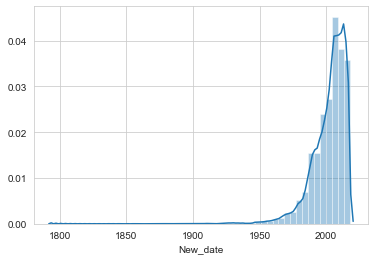

In [276]:
#Age distribution
sns.distplot(dataBook['New_date'])

### Langue column

In [ ]:
dataBook['Langue'].isna().sum()

In [ ]:
dataBook['Langue'].value_counts()

In [ ]:
dataBook[dataBook['Langue'].isna()]

In [ ]:
dataBook['Langue'].fillna('Unknown',inplace=True)


In [ ]:
dataBook['Langue'].nunique()

In [ ]:
dataBook.groupby('Langue')['Nombre_de_prêts_2017'].agg('sum').map(lambda x : x*100/dataBook['Nombre_de_prêts_2017'].sum()).sort_values(ascending=False).lt(0.25)

In [ ]:
def GroupOther3(col):
    
    selection=dataBook.groupby(col)['Nombre_de_prêts_2017'].agg('sum').map(lambda x : x*100/dataBook['Nombre_de_prêts_2017'].sum()).sort_values(ascending=False).lt(0.25)

    return np.where(dataBook[col].isin(selection[selection==True].index) ,'Other',dataBook[col])

In [ ]:
def GroupOther(col):
    selection=(dataBook[col].value_counts(normalize=True)*100).lt(0.5)
    return np.where(dataBook[col].isin(selection[selection==True].index) ,'Other',dataBook[col])

In [ ]:
#Create new columns Language
dataBook['Language']=dataBook['Langue']


In [ ]:
dataBook['Language']=GroupOther3('Langue')


In [ ]:
dataBook.Language=dataBook['Language'].str.replace('sans','Unknown')
dataBook.Language=dataBook['Language'].str.replace('Unknown','Other')
dataBook.Language=dataBook['Language'].str.replace('multilingue','Other')

In [ ]:
dataBook['Language'].nunique()

In [ ]:
dataBook['Language'].isna().sum()

In [ ]:

# Plot Number of loans by language
dataBook.groupby('Language')["Nombre_de_prêts_2017"].agg('sum').sort_values(ascending=True).plot(kind='barh',figsize=(15,10))
plt.title('Number of loans 2017 by language')
plt.show()
dataBook.groupby('Language')["Nombre_de_prêts_2017"].agg('sum').sort_values(ascending=False)



In [ ]:
#dataBook['Edition'].value_counts()

In [ ]:
to_drop.append('Edition')

In [ ]:
dataBook['Editeur'].isna().sum()

In [ ]:
dataBook['Editeur'].value_counts()

In [ ]:
dataBook['Editeur'].nunique()

In [ ]:
dataBook['Editeur'].fillna('Unknown',inplace=True)

In [ ]:
#dataBook.groupby('Editeur')['Nombre_de_prêts_2017'].agg('sum').map(lambda x : x*100/dataBook['Nombre_de_prêts_2017'].sum()).sort_values(ascending=False).lt(0.25)



In [ ]:
#selectop, depending on count of records
dataBook['Publisher']=dataBook['Editeur']
dataBook['Publisher']=GroupOther('Editeur')
    

In [ ]:
dataBook.Publisher.nunique()

In [ ]:
dataBook['Format'].value_counts()

In [ ]:
to_drop.append('Format')

In [ ]:
dataBook['Collection'].value_counts().head(10)

In [ ]:
dataBook['Collection'].isna().sum()
dataBook['Collection']=dataBook['Collection'].fillna('Unknown')

In [ ]:
dataBook['New_Collection']=dataBook['Collection']
dataBook['New_Collection']=np.where(dataBook['Collection'].isin(dataBook['Collection'].value_counts().head(15).index) ,dataBook['Collection'],'Other')

In [ ]:
dataBook['New_Collection'].value_counts()

In [ ]:
dataBook['Titre_de_série'].value_counts()

In [ ]:
to_drop.extend(['Titre_de_série','N°','Dates','EAN','ISSN','New_Collection','Collection','Cote_majoritaire'])

In [ ]:
dataBook.shape

In [ ]:
to_drop

In [ ]:
df=dataBook.drop(columns=to_drop)


In [ ]:
df

In [ ]:
dataBook.shape, df.shape

In [ ]:
#Reduce scope of study to Books, BD

In [ ]:
#df1=df.drop(dataBook.iloc[:,38:97],axis=1)

In [ ]:
#df1.shape

In [ ]:
#df1.head()

In [ ]:
df.groupby('DocType')['Nombre_de_prêts_2017'].agg('sum').sort_values(ascending=True).plot(kind='barh',figsize=(15,10))

In [ ]:
fig, ax = plt.subplots(figsize=(35,25))
sns.scatterplot(df.DocType,df['Nombre_de_prêts_2017'])
plt.title('Loans per doc Type')
plt.show()

In [ ]:
df[df.DocType=='Magazine']['Nombre_de_prêts_2017'].max()

In [ ]:
df[df.DocType=='Book']['Nombre_de_prêts_2017'].max()

In [ ]:
#magazine le plus emprunté
df[(df.DocType=='Magazine')&(df['Nombre_de_prêts_2017']==12745.0)]

In [ ]:
df[(df.Titre=="J'aime lire")]["Nombre_d'exemplaires"]

In [ ]:
df[(df.Titre=="J'aime lire")]["Nombre_d'exemplaires"]/54

In [ ]:
df['DateAge']=df['Date'].map(lambda x : findDate2(x))

In [ ]:
df['DateAge']=df.DateAge.astype(str).str.replace('[','').str.replace(']','').str.replace("'",'')

In [ ]:
df['DateAge']

In [ ]:
list(df.DateAge.value_counts().index)

In [ ]:
df.head()

In [ ]:
df.isna().sum()

In [ ]:
df.Nombre_de_localisations=df.Nombre_de_localisations.astype('int')

In [ ]:
df["Nombre_d'exemplaires"]=df["Nombre_d'exemplaires"].astype('int')

In [ ]:
# Dummies
df.Language.unique()

In [ ]:
Dummies_NA.append('Language')

In [ ]:
df.Nombre_de_prêts_2017=df.Nombre_de_prêts_2017.astype('int')

In [ ]:
df.Catégorie_statistique_1.nunique()

In [ ]:
def GroupOther4(col):
    
    selection=dataBook.groupby(col)['Nombre_de_prêts_2017'].agg('sum').map(lambda x : x*100/dataBook['Nombre_de_prêts_2017'].sum()).sort_values(ascending=False).lt(1)

    return np.where(dataBook[col].isin(selection[selection==True].index) ,'Other',dataBook[col])

In [ ]:
df['Categories_stat']=df.Catégorie_statistique_1

In [ ]:
df['Categories_stat']=GroupOther4('Catégorie_statistique_1')

In [ ]:
df['Categories_stat'].nunique()

In [ ]:
Dummies_NA.append('Categories_stat')

In [ ]:
df.DocType.unique()

In [ ]:
Dummies_NA.append('DocType')

In [ ]:
df.Publisher.unique()

In [ ]:
Dummies_NA.append('Publisher')

In [ ]:
Dummies_NA

In [ ]:
df.columns

In [ ]:
df1=df[['Language','Publisher','Categories_stat','DocType','Nombre_de_localisations',"Nombre_d'exemplaires",'Nombre_de_prêts_2017']]

In [ ]:
df1.shape

In [ ]:
df1=pd.get_dummies(data=df1, columns=Dummies_NA,drop_first=True)

In [ ]:
df.to_csv('bookcleanedV1.csv')

In [ ]:
“

In [ ]:
df1

In [ ]:
df1['Nombre_de_prêts_2017'].sum()

# Modelling

In [ ]:
from statsmodels.formula.api import ols
from statsmodels.api import OLS
from statsmodels.api import add_constant

In [ ]:
y=df1['Nombre_de_prêts_2017']
X=df1.drop('Nombre_de_prêts_2017',axis=1)

In [ ]:
model=OLS(y,X)

In [ ]:
model_fit=model.fit()

In [ ]:
model_fit.summary()

In [ ]:
LS Regression Results
Dep. Variable:	Nombre_de_prêts_2017	R-squared (uncentered):	0.621
Model:	OLS	Adj. R-squared (uncentered):	0.621
Method:	Least Squares	F-statistic:	2.964e+04
Date:	Mon, 20 Jul 2020	Prob (F-statistic):	0.00
Time:	02:18:40	Log-Likelihood:	-3.9296e+06
No. Observations:	815531	AIC:	7.859e+06
Df Residuals:	815486	BIC:	7.860e+06
Df Model:	45		
Covariance Type:	nonrobust	

In [ ]:
OLS(y,add_constant(X)).fit().summary()

# P-Hacking

In [ ]:
def func(column, X=X,y=y):
    if column:
        X=X.drop(column, axis=1)
    
    #buildthemodel
    model=OLS(y,add_constant(X))
    model_fit=model.fit()
    display(model_fit.summary())
    return X

In [ ]:
OLS Regression Results
Dep. Variable:	Nombre_de_prêts_2017	R-squared:	0.599
Model:	OLS	Adj. R-squared:	0.599
Method:	Least Squares	F-statistic:	2.708e+04
Date:	Mon, 20 Jul 2020	Prob (F-statistic):	0.00
Time:	02:27:12	Log-Likelihood:	-3.9296e+06
No. Observations:	815531	AIC:	7.859e+06
Df Residuals:	815485	BIC:	7.860e+06
Df Model:	45		
Covariance Type:	nonrobust		


In [ ]:
X=func("Publisher_Actes Sud",X)

In [ ]:
# No change of results after removing 12 columns.

In [ ]:
X.shape,df1.shape

# Assumptions check

In [ ]:
tester=Assumption_Tester_OLS(X,y)

In [ ]:
tester.run_all()

In [ ]:
X.to_csv('X1.csv',index=False)
y.to_csv('y1.csv',index=False)

In [ ]:
X=pd.read_csv('X1csv')
y=pd.read_csv('y1.csv')

In [ ]:
y.plot.box()

In [ ]:
#X=X.drop(['Categories_stat_Other','Publisher_Other','DocType_Book'],axis=1)


In [ ]:
summary=y.describe()
summary['IQR']=summary['75%']-summary['25%']

In [ ]:
model_fit=OLS(y,add_constant(X)).fit()

In [ ]:
y_pred=pd.Series(model_fit.predict(),index=y.index)

In [ ]:
(y_pred-y).describe().round(2)

In [ ]:
MSE,RMSE, MAE

In [ ]:
# Mean squared error
(model_fit.resid**2).mean()

In [ ]:
# Root Mean Squared Error
(model_fit.resid**2).mean()**0.5

In [ ]:
# Mean Absolute Error
model_fit.resid.abs().mean()